In [2]:
import pandas as pd
import numpy as np
import h2o

In [3]:
# Importing train and test
train = pd.read_csv('../data/stores_train.csv')
test = pd.read_csv('../data/stores_test.csv')

In [4]:
# Removing null revenue value rows
train = train[train['revenue'] != 0]

In [5]:
# Importing externally created features

gk_concepts = pd.read_csv('gk_concepts.csv')
chain_count = pd.read_csv('chain_count.csv')
competing_count = pd.read_csv('competing_count.csv')
busstops = pd.read_csv('grunnkrets_busstops.csv')
income = pd.read_csv('income2016_normalized.csv')
income = income.drop(['year'], axis=1)
population_distribution = pd.read_csv('population_distribution.csv')
std_mean_per_hierarchy_id = pd.read_csv('std_mean_per_hierarchy_id.csv')
area = pd.read_csv('../data/grunnkrets_norway_stripped.csv')
area = area[area['year'] == 2016]
area = area[['grunnkrets_id','area_km2']]
difference_population = pd.read_csv('difference_population.csv')
difference_income = pd.read_csv('difference_income.csv')
hotspots = pd.read_csv('hotspots.csv')


In [6]:
# Merging train and test with relevant features

train = train.merge(gk_concepts, on='grunnkrets_id', how='left')
train = train.merge(chain_count, on='chain_name', how='left')
train = train.merge(competing_count, on=['grunnkrets_id', 'plaace_hierarchy_id'], how='left')
train = train.merge(income, on='grunnkrets_id', how='left')
train = train.merge(population_distribution, on='grunnkrets_id', how='left')
train = train.merge(std_mean_per_hierarchy_id, on='plaace_hierarchy_id', how='left')
train = train.merge(area, on='grunnkrets_id', how='left')
train = train.merge(difference_population, on='grunnkrets_id', how='left')
train = train.merge(difference_income, on='grunnkrets_id', how='left')
train = train.merge(hotspots, on='grunnkrets_id', how='left')

test = test.merge(gk_concepts, on='grunnkrets_id', how='left')
test = test.merge(chain_count, on='chain_name', how='left')
test = test.merge(competing_count, on=['grunnkrets_id', 'plaace_hierarchy_id'], how='left')
test = test.merge(income, on='grunnkrets_id', how='left')
test = test.merge(population_distribution, on='grunnkrets_id', how='left')
test = test.merge(std_mean_per_hierarchy_id, on='plaace_hierarchy_id', how='left')
test = test.merge(area, on='grunnkrets_id', how='left')
test = test.merge(difference_population, on='grunnkrets_id', how='left')
test = test.merge(difference_income, on='grunnkrets_id', how='left')
test = test.merge(hotspots, on='grunnkrets_id', how='left')


In [7]:
# Creating a binary encoding for mall name
train[['mall_name']] = train[['mall_name']].where(train[['mall_name']].isnull(), 1).fillna(0).astype(int)
test[['mall_name']] = test[['mall_name']].where(test[['mall_name']].isnull(), 1).fillna(0).astype(int)

# Removing NaN values from num_people and replacing with median value
train['num_people'] = train['num_people'].fillna(train['num_people'].median(skipna=True))
test['num_people'] = test['num_people'].fillna(test['num_people'].median(skipna=True))

# Creating density feature by dividing num_people by area
train['density'] = train.num_people/train.area_km2
test['density'] = test.num_people/test.area_km2


In [8]:
# Dropping irrelevant columns
train.drop(['store_name', 'grunnkrets_id', 'address', 'lat', 'lon','year'], axis=1, inplace=True)
test.drop(['store_name', 'grunnkrets_id', 'address', 'lat', 'lon', 'year'], axis=1, inplace=True)

In [9]:
# Removing all entries that lie more than 'factor' std_devs away from mean. 5 and 6 are ok values
factor = 6
train = train[(np.abs(train['revenue'] - train['mean']) <= factor * train['std_dev'])]


In [10]:
# Log normalizing values in revenue
train['revenue'] = train['revenue'] +1
train['revenue'] = np.log(train['revenue'])

In [11]:
# Dropping unused id column
X_train = train.drop(columns=['store_id'])
X_test = test.drop(columns=['store_id'])

In [12]:
from h2o.automl import H2OAutoML
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,3 hours 35 mins
H2O_cluster_timezone:,Europe/Oslo
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.38.0.2
H2O_cluster_version_age:,17 days
H2O_cluster_name:,H2O_from_python_henriklatsch_tqqqex
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,8.89 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [13]:
df = h2o.H2OFrame(X_train)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [14]:
df_test = h2o.H2OFrame(X_test)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
# Setting features as factor
df['chain_name'] = df['chain_name'].asfactor()
df['mall_name'] = df['mall_name'].asfactor()
df['chain_count'] = df['chain_count'].asnumeric()
df['plaace_hierarchy_id'] = df['plaace_hierarchy_id'].asfactor()
df['sales_channel_name'] = df['sales_channel_name'].asfactor()

df_test['chain_name'] = df_test['chain_name'].asfactor()
df_test['mall_name'] = df_test['mall_name'].asfactor()
df_test['chain_count'] = df_test['chain_count'].asnumeric()
df_test['plaace_hierarchy_id'] = df_test['plaace_hierarchy_id'].asfactor()
df_test['sales_channel_name'] = df_test['sales_channel_name'].asfactor()

In [16]:
# x denotes all columns that the model will look at. Can quickly add or remove features in testing
y = "revenue"
x = df.columns
x.remove(y)
x.remove('sales_channel_name')
x.remove('couple_with_children')
x.remove('other_households')
x.remove('single_parent_with_children')
x.remove('area_km2')
x.remove('std_dev')
x.remove('mean')


In [23]:
# Training
aml = H2OAutoML(max_models = 10, seed = 1,balance_classes=False, max_runtime_secs=1000, include_algos=['GLM','StackedEnsemble'])
aml.train(x = x, y = y, training_frame = df)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_10_20221113_213117


GLM Model: summary
    family    link      regularization               lambda_search                                                                    number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------  -------------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ------------------------------------------------
    gaussian  identity  Ridge ( lambda = 6.414E-5 )  nlambda = 30, lambda.max = 39.833, lambda.min = 6.414E-5, lambda.1se = 4.312E-4  410                           410                            29                      AutoML_10_20221113_213117_training_py_5_sid_8659

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 0.43878293931689316
RMSE: 0.6624069287959579
MAE: 0.5060221056573074
RMSLE: 0.28561480304471665
Mean Residual Deviance: 0.43878293931689316
R^2: 0.5663968159082189
Null degrees of freedom: 12602
Residual degrees of freedom: 12192
Null deviance: 12753.553449551819
Residual deviance: 5529.981384210804
AIC: 26208.037977822405

ModelMetricsRegressionGLM: glm
** Reported on cross-validation data. **

MSE: 0.46556714754149986
RMSE: 0.6823248108793201
MAE: 0.522146474289813
RMSLE: NaN
Mean Residual Deviance: 0.46556714754149986
R^2: 0.5399287905386292
Null degrees of freedom: 12602
Residual degrees of freedom: 12207
Null deviance: 12755.223369204308
Residual deviance: 5867.542760465522
AIC: 26924.78447094857

Cross-Validation Metrics Summary: 
                        mean      sd         cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  --------  ---------  ------------  ------------  ------------  ------------  ------------
mae                     0.522127  0.0108313  0.537191      0.510254      0.513191      0.523414      0.526587
mean_residual_deviance  0.465458  0.020133   0.497399      0.445609      0.452475      0.470272      0.461534
mse                     0.465458  0.020133   0.497399      0.445609      0.452475      0.470272      0.461534
null_deviance           2551.04   55.6333    2617.52       2503.19       2492.32       2597.73       2544.46
r2                      0.54007   0.0113116  0.520933      0.551153      0.541998      0.543492      0.542774
residual_deviance       1173.23   50.7502    1253.94       1123.38       1140.69       1185.09       1163.06
rmse                    0.682119  0.014651   0.705265      0.66754       0.672662      0.685764      0.679363
rmsle                   0.290694  0.0014228  nan           0.288681      0.291081      0.290981      0.292031

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train       deviance_xval        deviance_se           alpha    iterations    training_rmse       training_deviance    training_mae        training_r2
---  -------------------  ----------  -----------  --------  ------------  -------------------  -------------------  --------------------  -------  ------------  ------------------  -------------------  ------------------  ------------------
     2022-11-13 21:31:17  0.000 sec   1            ,4E2      411           0.999297181776898    1.001899435129854    0.009906716220513138  0.0
     2022-11-13 21:31:17  0.001 sec   2            ,25E2     411           0.9920978930844927   0.9960321447505533   0.009908873736098405  0.0
     2022-11-13 21:31:17  0.003 sec   3            ,15E2     411           0.981246384137868    0.9870851071338256   0.00991213347063992   0.0
     2022-11-13 21:31:17  0.005 sec   4            ,95E1     411           0.9654517472104416   0.9738420462988803   0.009915870134955743  0.0
     2022-11-13 21:31:17  0.006 sec   5            ,59E1     411           0.94361798830019

In [18]:
# Print best performing model
best_model = aml.get_best_model()
print(best_model)

Model Details
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_AllModels_1_AutoML_9_20221113_201724

No summary for this model

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.3327281178210787
RMSE: 0.576825899055407
MAE: 0.4400027337367392
RMSLE: 0.2535232946824804
Mean Residual Deviance: 0.3327281178210787
R^2: 0.6728782730168856
Null degrees of freedom: 10049
Residual degrees of freedom: 10040
Null deviance: 10222.421438952262
Residual deviance: 3343.917584101841
AIC: 17483.347183250433

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.4556695072693025
RMSE: 0.6750329675425508
MAE: 0.5168712678418346
RMSLE: 0.2896662395746958
Mean Residual Deviance: 0.4556695072693025
R^2: 0.5497095909127312
Null degrees of freedom: 12602
Residual degrees of freedom: 12593
Null deviance: 12757.373170680585
Residual deviance: 5742.80280011502
AIC: 25881.964243303755

Cross-Validation Metrics Summary: 

In [19]:
# Print leaderboard
lb = aml.leaderboard
lb.head(10)

model_id,rmse,mse,mae,rmsle,mean_residual_deviance
StackedEnsemble_AllModels_1_AutoML_9_20221113_201724,0.675033,0.45567,0.516871,0.289666,0.45567
StackedEnsemble_BestOfFamily_1_AutoML_9_20221113_201724,0.675415,0.456185,0.517662,0.289842,0.456185
GBM_1_AutoML_9_20221113_201724,0.679136,0.461225,0.520526,0.291037,0.461225
GBM_2_AutoML_9_20221113_201724,0.681396,0.4643,0.522368,0.291965,0.4643
GLM_1_AutoML_9_20221113_201724,0.682325,0.465567,0.522146,nan,0.465567
GBM_3_AutoML_9_20221113_201724,0.684723,0.468846,0.525021,0.292974,0.468846
GBM_4_AutoML_9_20221113_201724,0.689224,0.475029,0.528342,0.294575,0.475029
DRF_1_AutoML_9_20221113_201724,0.696757,0.48547,0.532532,0.297339,0.48547
XGBoost_3_AutoML_9_20221113_201724,0.697699,0.486784,0.53813,0.296769,0.486784
XGBoost_2_AutoML_9_20221113_201724,0.727217,0.528845,0.559369,0.308029,0.528845


# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
DRF_1_AutoML_9_20221113_201724,0.359167,0.129001,0.266457,0.164818,0.129001,4450,0.028097,DRF
XGBoost_1_AutoML_9_20221113_201724,0.485561,0.23577,0.365145,0.214038,0.23577,1726,0.006491,XGBoost
XRT_1_AutoML_9_20221113_201724,0.486001,0.236197,0.382146,0.215453,0.236197,4381,0.028634,DRF
GBM_4_AutoML_9_20221113_201724,0.519972,0.270371,0.391242,0.233103,0.270371,492,0.010497,GBM
XGBoost_2_AutoML_9_20221113_201724,0.539382,0.290933,0.411091,0.23599,0.290933,1147,0.003787,XGBoost
GBM_3_AutoML_9_20221113_201724,0.571509,0.326623,0.434854,0.253662,0.326623,337,0.008572,GBM
StackedEnsemble_BestOfFamily_1_AutoML_9_20221113_201724,0.575876,0.331633,0.440785,0.25242,0.331633,635,0.030016,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_9_20221113_201724,0.577332,0.333313,0.440813,0.253268,0.333313,852,0.032114,StackedEnsemble
GBM_2_AutoML_9_20221113_201724,0.593185,0.351868,0.451758,0.261471,0.351868,310,0.007696,GBM
GBM_1_AutoML_9_20221113_201724,0.612569,0.375241,0.466012,0.265967,0.375241,459,0.010498,GBM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

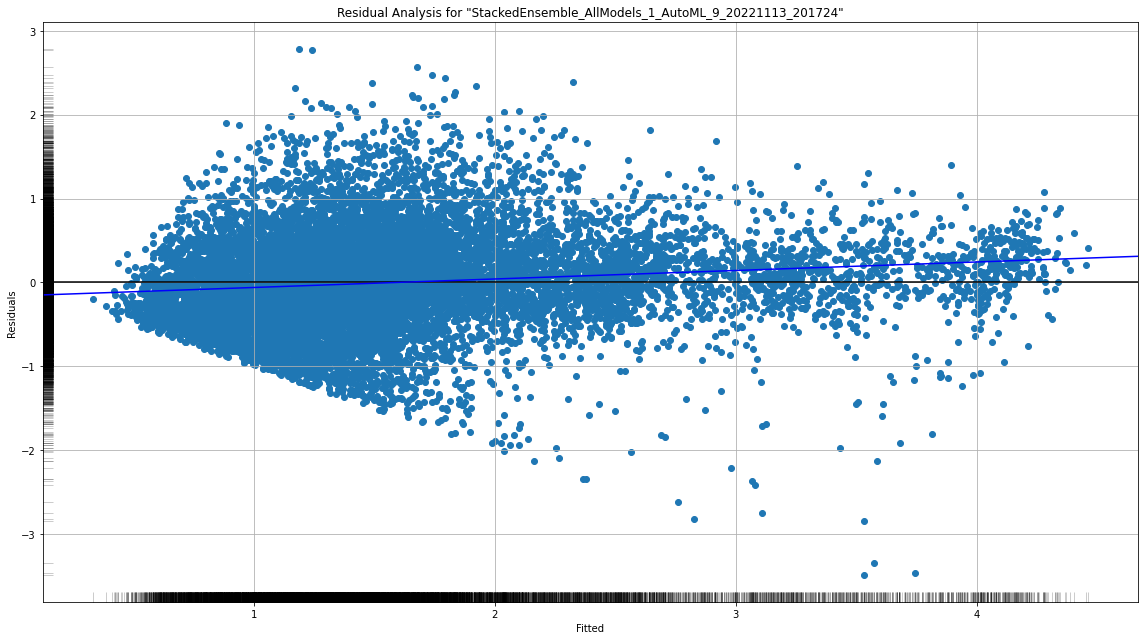

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

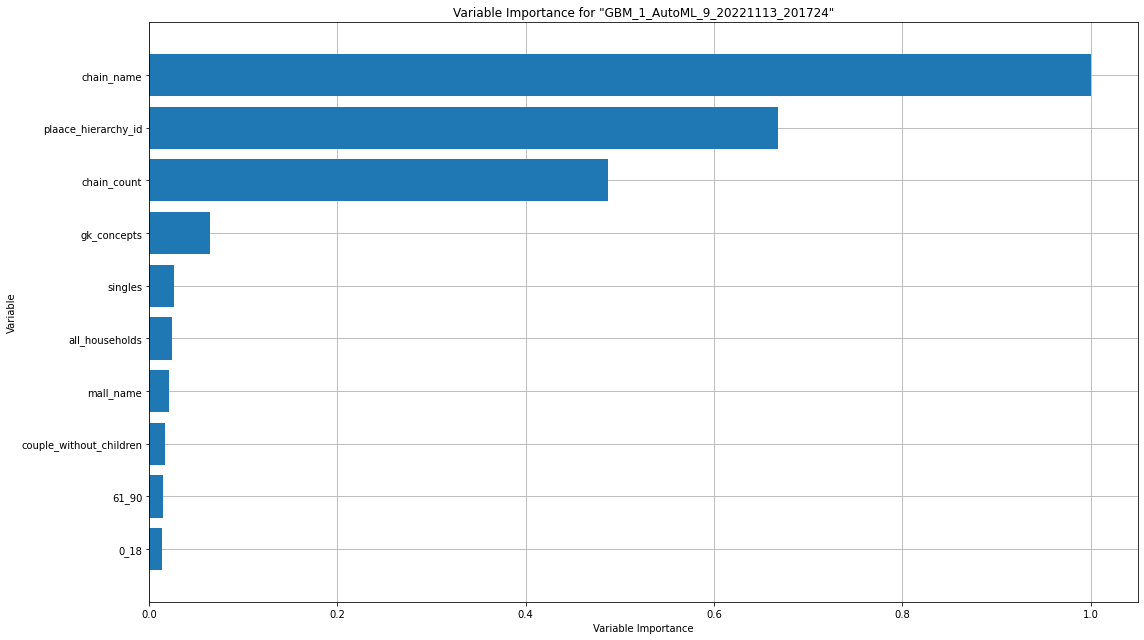

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

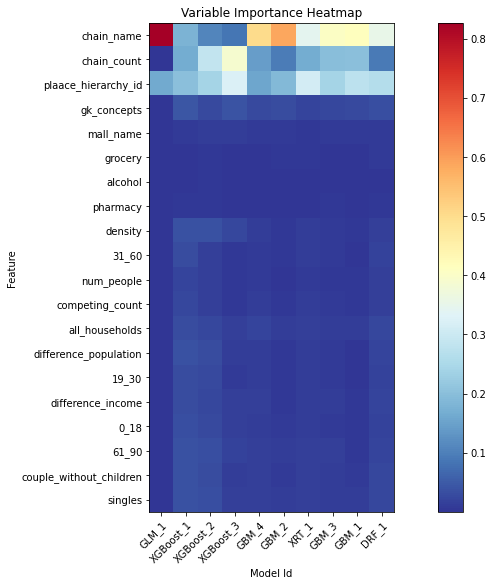

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

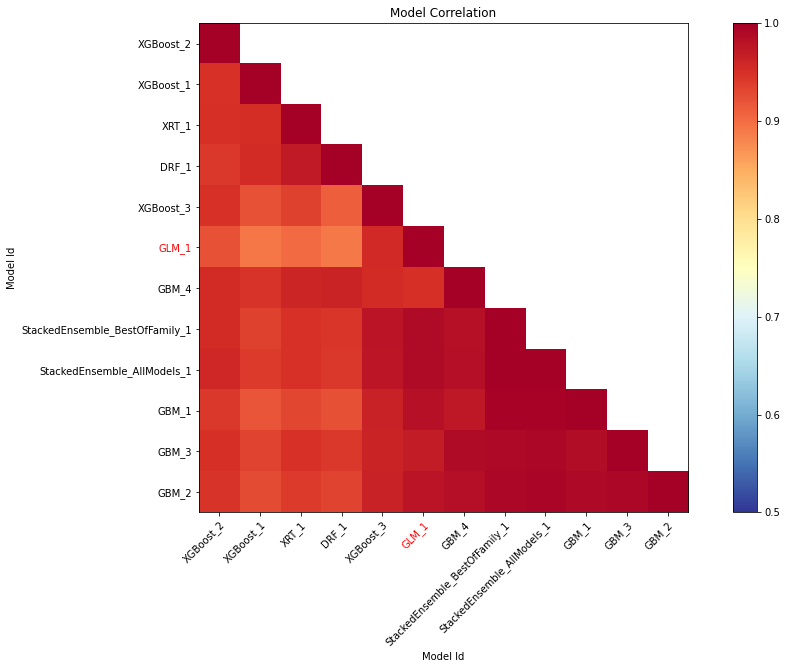

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

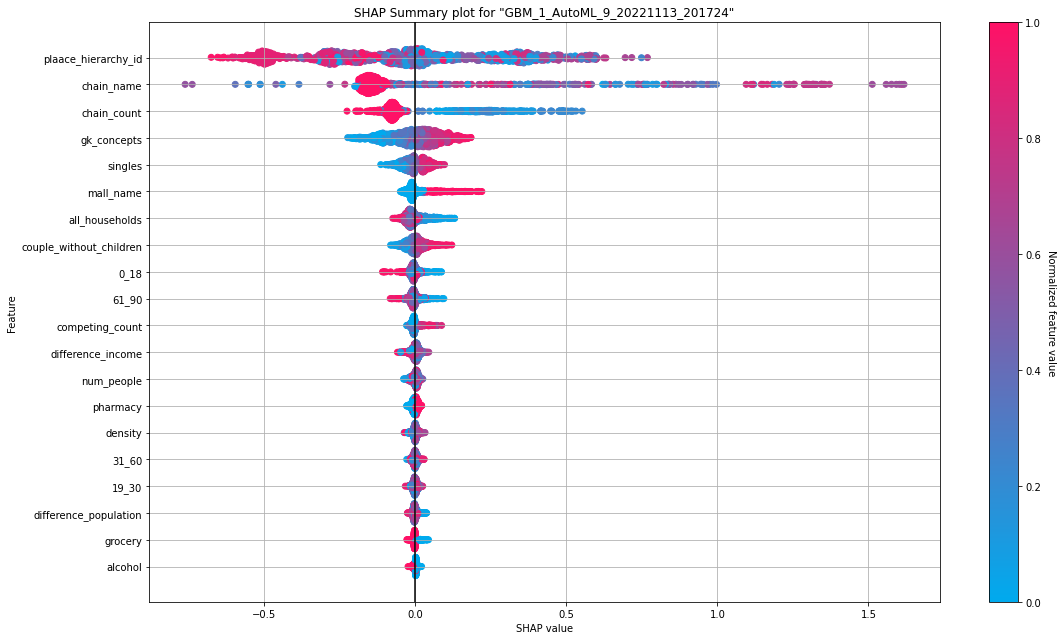

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

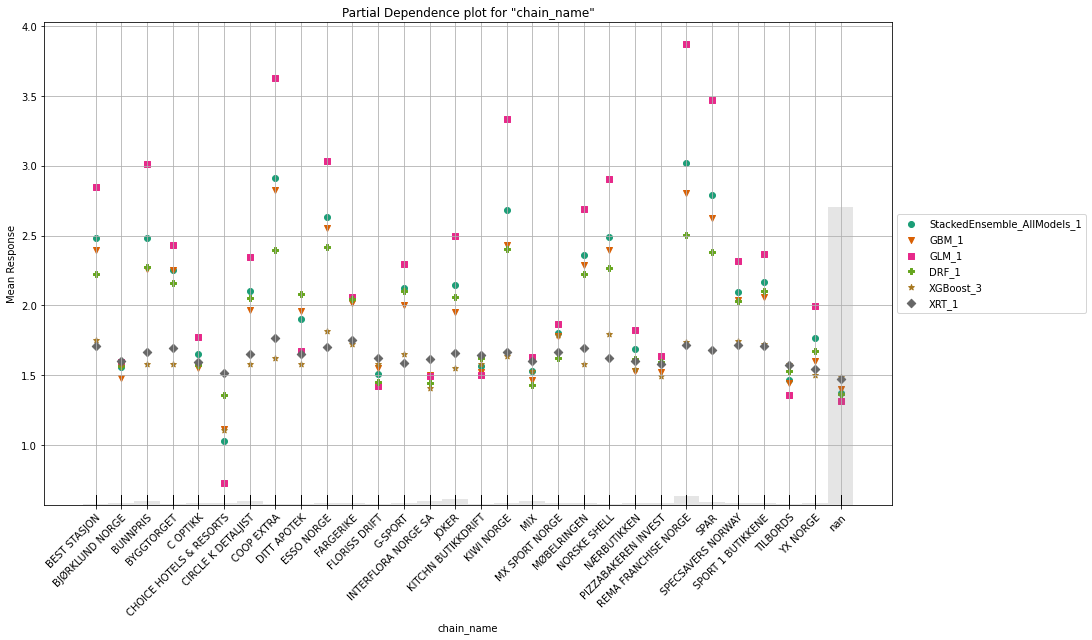

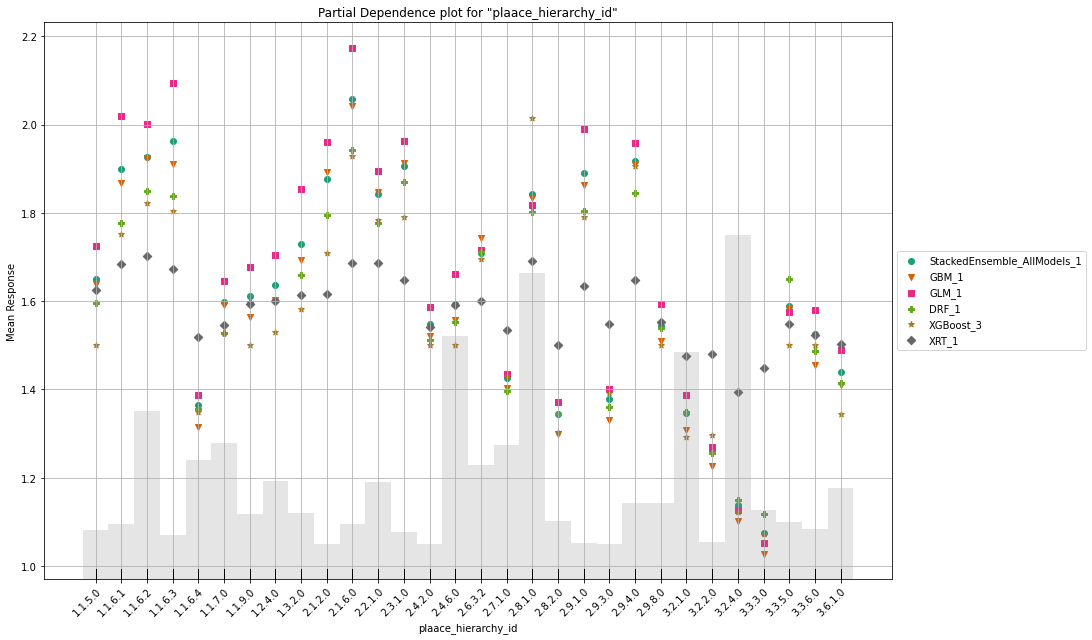

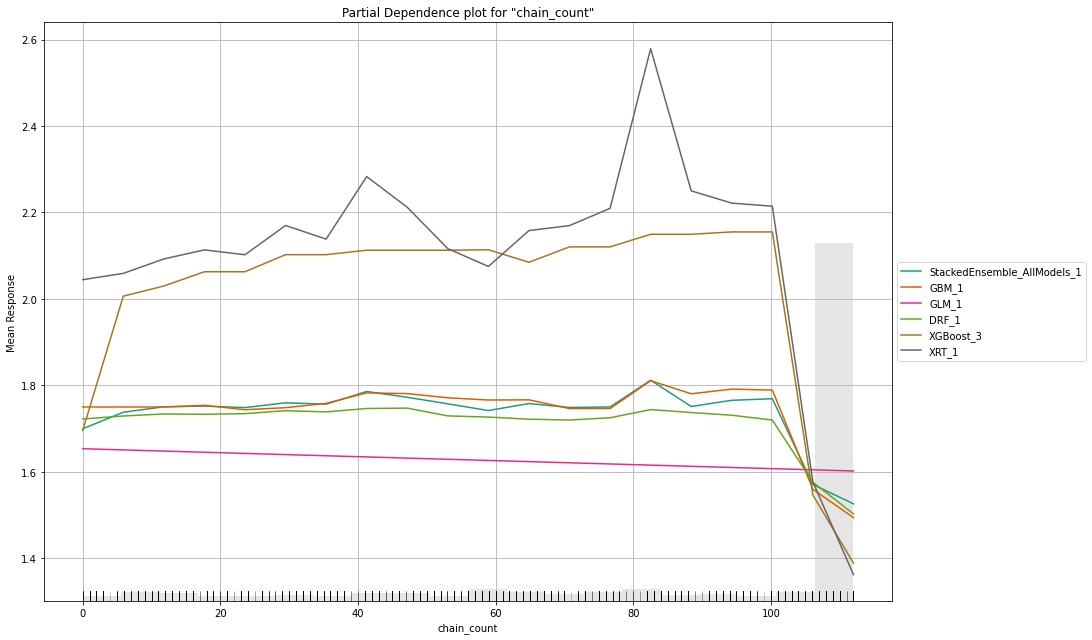

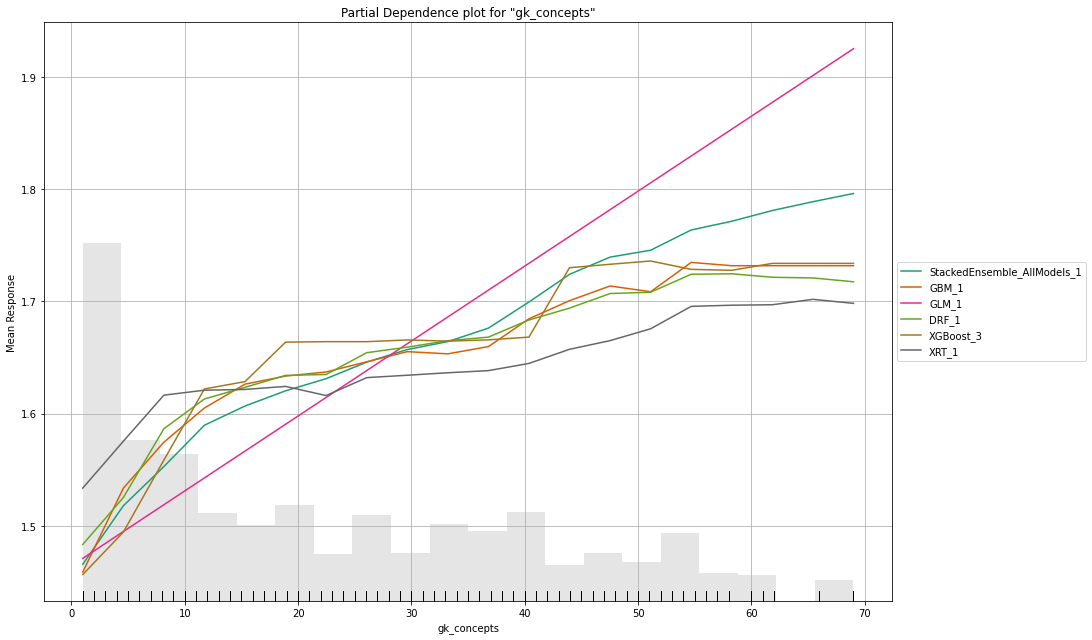

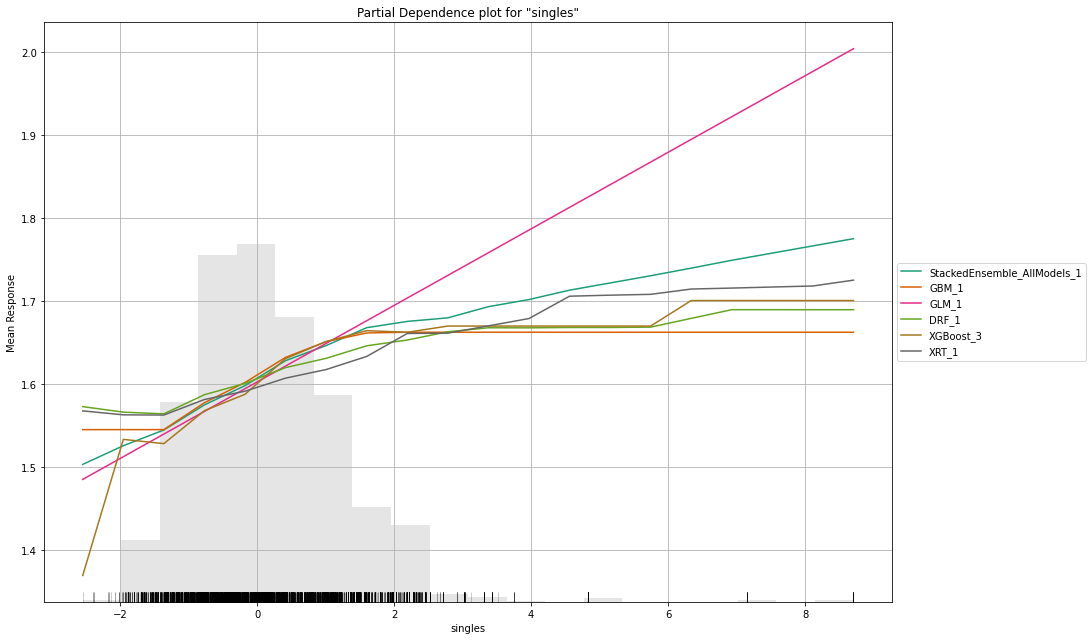

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

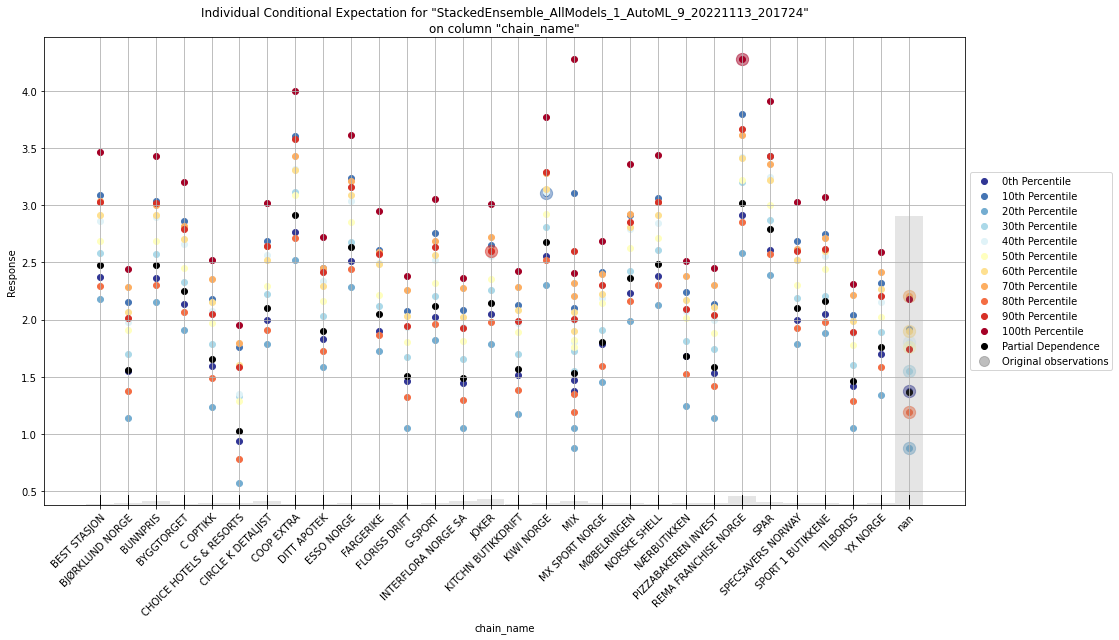

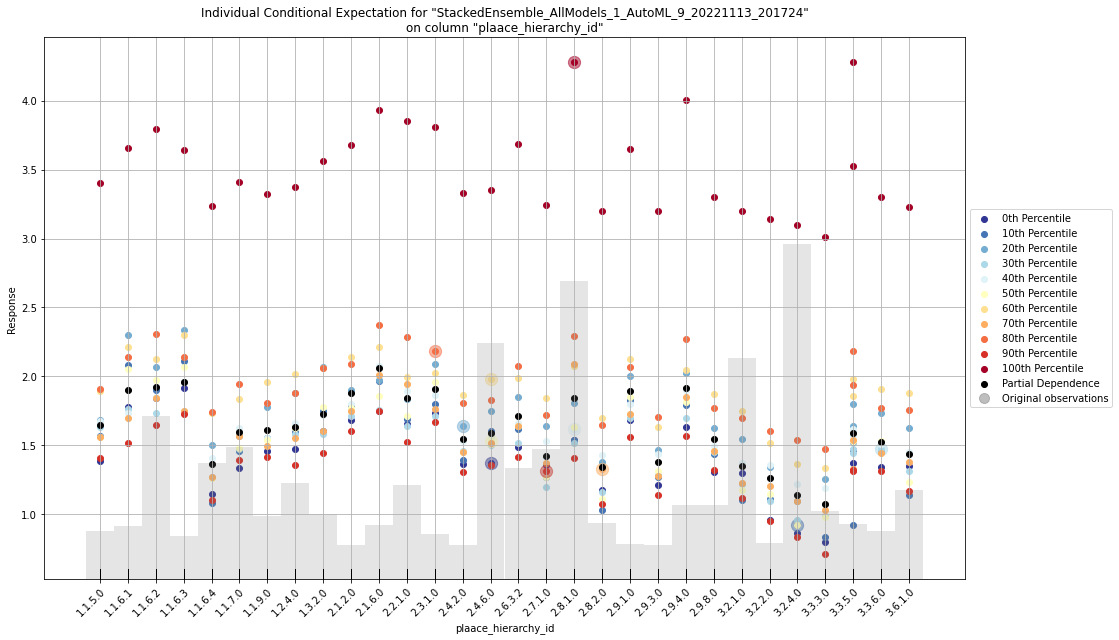

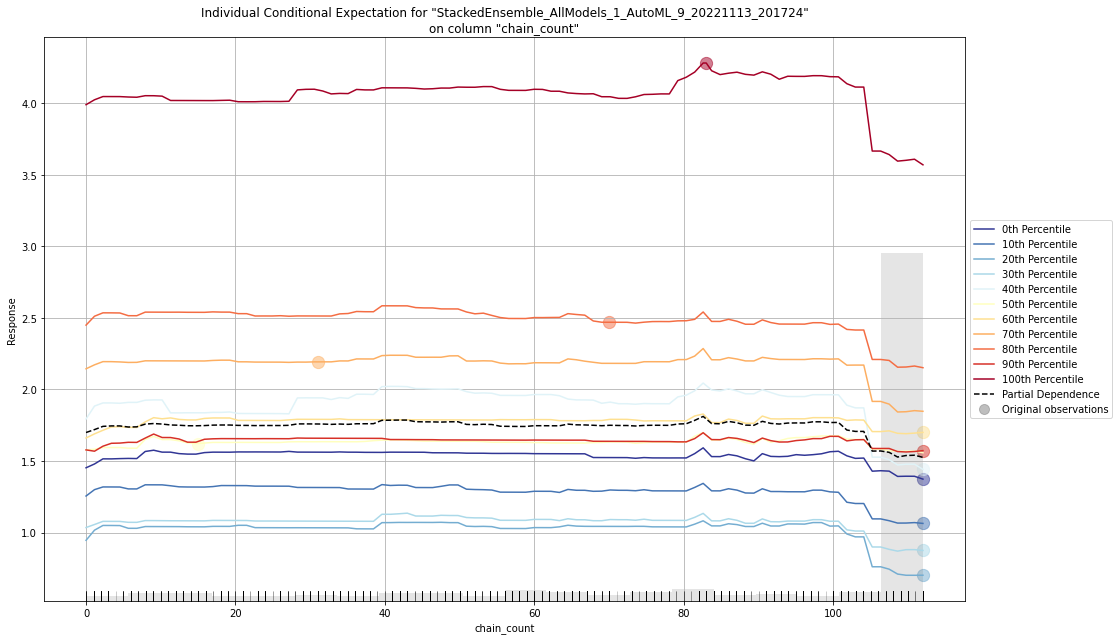

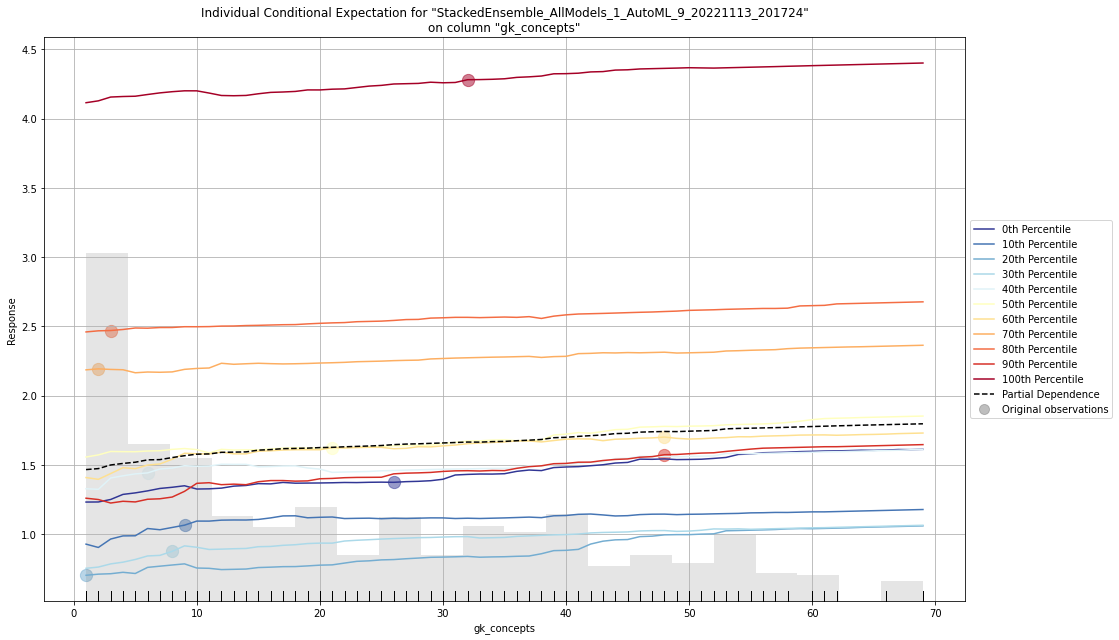

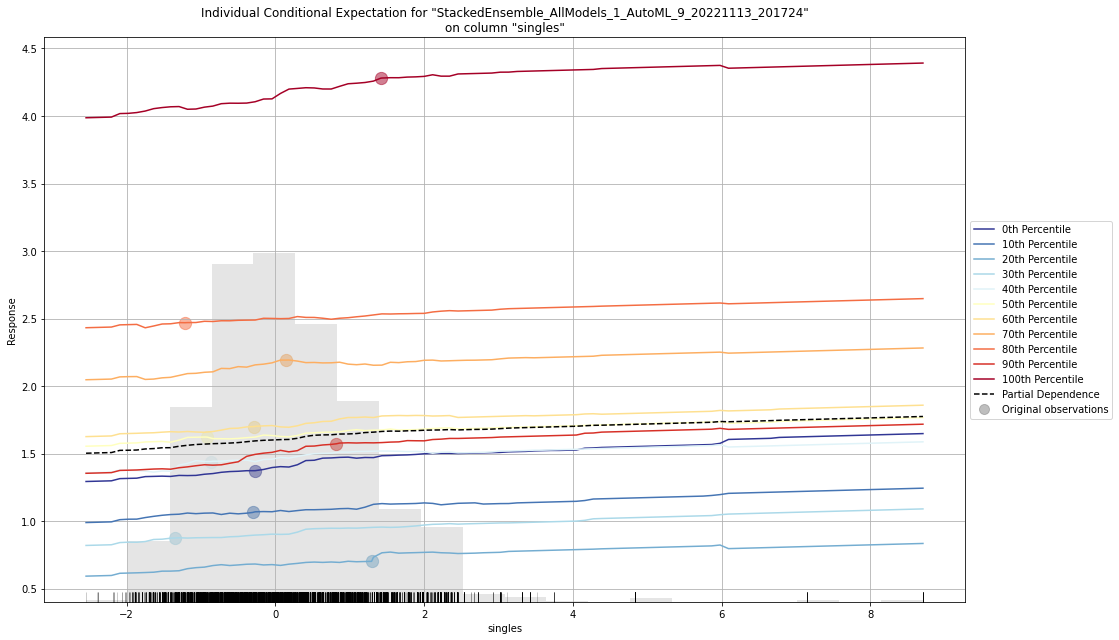

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id,rmse,mse,mae,rmsle,mean_residual_deviance,training_time_ms,predict_time_per_row_ms,algo
DRF_1_AutoML_9_20221113_201724,0.359167,0.129001,0.266457,0.164818,0.129001,4450,0.028097,DRF
XGBoost_1_AutoML_9_20221113_201724,0.485561,0.23577,0.365145,0.214038,0.23577,1726,0.006491,XGBoost
XRT_1_AutoML_9_20221113_201724,0.486001,0.236197,0.382146,0.215453,0.236197,4381,0.028634,DRF
GBM_4_AutoML_9_20221113_201724,0.519972,0.270371,0.391242,0.233103,0.270371,492,0.010497,GBM
XGBoost_2_AutoML_9_20221113_201724,0.539382,0.290933,0.411091,0.23599,0.290933,1147,0.003787,XGBoost
GBM_3_AutoML_9_20221113_201724,0.571509,0.326623,0.434854,0.253662,0.326623,337,0.008572,GBM
StackedEnsemble_BestOfFamily_1_AutoML_9_20221113_201724,0.575876,0.331633,0.440785,0.25242,0.331633,635,0.030016,StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_9_20221113_201724,0.577332,0.333313,0.440813,0.253268,0.333313,852,0.032114,StackedEnsemble
GBM_2_AutoML_9_20221113_201724,0.593185,0.351868,0.451758,0.261471,0.351868,310,0.007696,GBM
GBM_1_AutoML_9_20221113_201724,0.612569,0.375241,0.466012,0.265967,0.375241,459,0.010498,GBM


# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

In [20]:
# Print model explanation, with variable importance plots, SHAP analysis etc.
aml.explain(df)

In [21]:
# Output predictions to dataframe, and .describe()
preds = aml.predict(df_test)
preds = h2o.as_list(preds)

ids = test['store_id']
out = pd.DataFrame(ids)
out['predicted'] = np.exp(preds['predict'])
out['predicted'] = out['predicted'] -1
out = out.rename(columns={'store_id': 'id'})
out.describe()

stackedensemble prediction progress: |███████████████████████████████████████████| (done) 100%


/Users/henriklatsch/miniforge3/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'plaace_hierarchy_id' has levels not trained on: ["1.5.1.0", "2.2.2.0"]
  warnings.warn(w)
/Users/henriklatsch/miniforge3/lib/python3.9/site-packages/h2o/job.py:83: UserWarning: Test/Validation dataset column 'chain_name' has levels not trained on: ["24 7 TRENINGSSENTER", "ACE SHOPS", "AVANCIA SPORT", "BADEMILJØ", "BADERINGEN", "BAROKK FRISØR", "BERTONI NORWAY", "BIRK SPORT", "BLUE ENERGY", "DESINESS", ...25 not listed..., "SALT OG PEPPER HØNEFOSS", "SKOGSTAD DETALJ", "SKY FITNESS", "TIGER OF SWEDEN", "TIPPY", "VARMEFAG INVEST", "VITA EXCLUSIVE", "YOGIS", "ZAVANNA", "ZAXIZ FRISØR"]
  warnings.warn(w)


,predicted
count,8577.000000
mean,6.226840
std,9.527331
min,0.536909
25%,2.098815
50%,3.249823
75%,5.291421
max,78.731468


In [22]:
# Write predictions to file
out.to_csv('outputh2ofinal.csv', index=False)

In [ ]:
# Shutdown the h2o server
h2o.shutdown()